Đây là notebook chứa end-to-end pipeline

Mỗi notebook chỉ chứa 1 model thôi nhé

## Installations

## Data Preparation

Bước này đã được chuẩn bị ở notebook Data Preparation.

split_v3 https://drive.google.com/file/d/1qHL9NaEADU3fLY9jvxopnXk8vbA7vVFu/view?usp=drive_link

In [1]:
# Download dataset
!gdown 1qHL9NaEADU3fLY9jvxopnXk8vbA7vVFu
!unzip splits_v3.zip

Streaming output truncated to the last 5000 lines.
  inflating: splits_v3/train/glass/glass_489.jpg  
  inflating: splits_v3/train/glass/glass_566.jpg  
  inflating: splits_v3/augmented_data/glass/aug_2822_glass_19.jpg  
  inflating: splits_v3/train/glass/glass_591.jpg  
  inflating: splits_v3/train/glass/glass_616.jpg  
  inflating: splits_v3/augmented_data/glass/aug_2816_glass_2.jpg  
  inflating: splits_v3/train/compost/compost_1276.jpg  
  inflating: splits_v3/train/glass/glass_574.jpg  
  inflating: splits_v3/train/compost/compost_1251.jpg  
  inflating: splits_v3/train/compost/compost_1212.jpg  
  inflating: splits_v3/train/compost/compost_1178.jpg  
  inflating: splits_v3/train/glass/glass_465.jpg  
  inflating: splits_v3/train/glass/glass_571.jpg  
  inflating: splits_v3/train/compost/compost_1173.jpg  
  inflating: splits_v3/train/compost/compost_1176.jpg  
  inflating: splits_v3/train/compost/compost_1190.jpg  
  inflating: splits_v3/train/glass/glass_499.jpg  
  inflating: s

### Load datasets

In [2]:
TRAIN_PATH = '/content/splits_v3/train'
DEV_PATH = '/content/splits_v3/validation'
TEST_PATH = '/content/splits_v3/test'

In [3]:
from keras.preprocessing.image import ImageDataGenerator

# Data generators
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest')
# Data flow
train_generator = train_datagen.flow_from_directory(
    directory=TRAIN_PATH,
    target_size=(256, 256),
    color_mode="rgb",
    batch_size=32,
    class_mode="categorical",
    shuffle=True,
    seed=42
)

Found 3260 images belonging to 7 classes.


In [4]:
# Data generators
valid_datagen = ImageDataGenerator(
    rescale=1./255,) # dont augment valid set

valid_generator = valid_datagen.flow_from_directory(
    directory=DEV_PATH,
    target_size=(224, 224),
    color_mode="rgb",
    batch_size=32,
    class_mode="categorical",
    shuffle=True,
    seed=42
)

Found 699 images belonging to 7 classes.


In [5]:

test_datagen = ImageDataGenerator(
    rescale=1./255,) # dont augment test set

test_generator = test_datagen.flow_from_directory(
    directory=TEST_PATH,
    target_size=(224, 224),
    color_mode="rgb",
    batch_size=1,
    class_mode=None,
    shuffle=False,
    seed=42
)

Found 699 images belonging to 7 classes.


### Prepare

## Model Training

### Construct model

In [7]:
import tensorflow as tf
from tensorflow.keras.metrics import AUC
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

###### Transfer pretrained model

In [8]:
# Create the base model from the pre-trained model ResNet50
IMG_SHAPE = (256, 256, 3)
base_model = MobileNetV2(input_shape = IMG_SHAPE,
                                         include_top = False,
                                         weights = 'imagenet')
#base_model.trainable = False
base_model.summary()


9406464/9406464 [==============================] - 0s 0us/step
Model: "mobilenetv2_1.00_224"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 128, 128, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 128, 128, 32  128         ['Conv1[0][0]']                  
                

In [9]:
n_classes = 7

model = tf.keras.Sequential([
    base_model,
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dense(512, activation = 'relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(n_classes, activation = 'softmax')
])


In [10]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_1.00_224 (Funct  (None, 8, 8, 1280)       2257984   
 ional)                                                          
                                                                 
 global_average_pooling2d (G  (None, 1280)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 512)               655872    
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                                 
 dense_1 (Dense)             (None, 7)                 3591      
                                                                 
Total params: 2,917,447
Trainable params: 2,883,335
Non-

In [11]:
model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate = 0.001),
              loss = 'categorical_crossentropy',
              metrics = ['accuracy'])


In [12]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_1.00_224 (Funct  (None, 8, 8, 1280)       2257984   
 ional)                                                          
                                                                 
 global_average_pooling2d (G  (None, 1280)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 512)               655872    
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                                 
 dense_1 (Dense)             (None, 7)                 3591      
                                                                 
Total params: 2,917,447
Trainable params: 2,883,335
Non-

In [ ]:
!nvidia-smi

Mon Jul 10 15:29:14 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.12    Driver Version: 525.85.12    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   64C    P0    29W /  70W |    641MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

### Hyperparameter tuning (nếu cần)

### Train model

In [13]:

# Model Checkpoint
tl_checkpoint_1 = ModelCheckpoint(filepath = 'mobilenetv2_best_weights.hdf5', save_best_only = True, verbose = 0)

# EarlyStopping
early_stop = EarlyStopping(monitor = 'val_loss', patience = 10, restore_best_weights = True, mode = 'min')

#ReduceLROnPlateau to stabilize the training process of the model
#help to solve gradient vanishing problem
rop_callback = ReduceLROnPlateau(monitor = 'val_loss', patience = 3, verbose = 1, factor = 0.5, min_lr = 0.000000001)

In [14]:
EPOCHS = 50
n_train_steps = train_generator.n//train_generator.batch_size
n_valid_steps = valid_generator.n//valid_generator.batch_size

https://pyimagesearch.com/2018/12/24/how-to-use-keras-fit-and-fit_generator-a-hands-on-tutorial/

`.fit()` nạp cả dataset vô RAM => ko đủ RAM để nạp nên dễ bị crash

`.fit_generator()`

In [15]:
history = model.fit_generator(train_generator,
            epochs=EPOCHS,
            verbose=1,
            steps_per_epoch=n_train_steps, #batch_size,
            validation_data=valid_generator,
            validation_steps=n_valid_steps,
            callbacks = [tl_checkpoint_1, early_stop, rop_callback])

<ipython-input-15-ba8a1dd06835>:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(train_generator,


Epoch 1/50
101/101 [==============================] - 111s 672ms/step - loss: 1.2288 - accuracy: 0.5530 - val_loss: 25.9347 - val_accuracy: 0.1592 - lr: 0.0010
Epoch 2/50
101/101 [==============================] - 62s 609ms/step - loss: 0.9543 - accuracy: 0.6738 - val_loss: 12.7835 - val_accuracy: 0.1711 - lr: 0.0010
Epoch 3/50
101/101 [==============================] - 61s 603ms/step - loss: 0.7988 - accuracy: 0.7289 - val_loss: 15.4863 - val_accuracy: 0.1637 - lr: 0.0010
Epoch 4/50
101/101 [==============================] - 61s 606ms/step - loss: 0.6587 - accuracy: 0.7776 - val_loss: 23.5578 - val_accuracy: 0.1577 - lr: 0.0010
Epoch 5/50
101/101 [==============================] - 62s 609ms/step - loss: 0.6575 - accuracy: 0.7782 - val_loss: 8.4823 - val_accuracy: 0.2961 - lr: 0.0010
Epoch 6/50
101/101 [==============================] - 61s 607ms/step - loss: 0.5632 - accuracy: 0.8138 - val_loss: 9.4469 - val_accuracy: 0.2693 - lr: 0.0010
Epoch 7/50
101/101 [===========================

In [17]:
history2 = model.fit_generator(train_generator,
            epochs=20,
            verbose=1,
            steps_per_epoch=n_train_steps, #batch_size,
            validation_data=valid_generator,
            validation_steps=n_valid_steps,
            callbacks = [tl_checkpoint_1, early_stop, rop_callback])

<ipython-input-17-a2833bc2ec4f>:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history2 = model.fit_generator(train_generator,


Epoch 1/20
101/101 [==============================] - 65s 637ms/step - loss: 0.0127 - accuracy: 0.9947 - val_loss: 0.5300 - val_accuracy: 0.9137 - lr: 3.1250e-05
Epoch 2/20
101/101 [==============================] - 63s 621ms/step - loss: 0.0113 - accuracy: 0.9972 - val_loss: 0.5094 - val_accuracy: 0.9167 - lr: 3.1250e-05
Epoch 3/20
101/101 [==============================] - 62s 614ms/step - loss: 0.0166 - accuracy: 0.9954 - val_loss: 0.5215 - val_accuracy: 0.9152 - lr: 3.1250e-05
Epoch 4/20
101/101 [==============================] - 62s 606ms/step - loss: 0.0113 - accuracy: 0.9963 - val_loss: 0.5393 - val_accuracy: 0.9122 - lr: 3.1250e-05
Epoch 5/20
101/101 [==============================] - ETA: 0s - loss: 0.0126 - accuracy: 0.9963
Epoch 5: ReduceLROnPlateau reducing learning rate to 1.5625000742147677e-05.
101/101 [==============================] - 71s 698ms/step - loss: 0.0126 - accuracy: 0.9963 - val_loss: 0.5588 - val_accuracy: 0.9167 - lr: 3.1250e-05
Epoch 6/20
101/101 [========

## Model Analysis


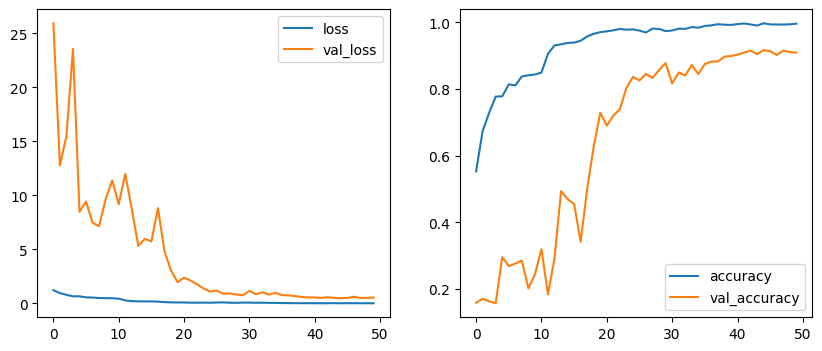

In [16]:
import matplotlib.pyplot as plt
import pandas as pd


fig, ax = plt.subplots(1, 2, figsize=(10, 4))

history_df = pd.DataFrame(history.history)
history_df[['loss', 'val_loss']].plot(kind='line', ax=ax[0])
history_df[['accuracy', 'val_accuracy']].plot(kind='line', ax=ax[1]);

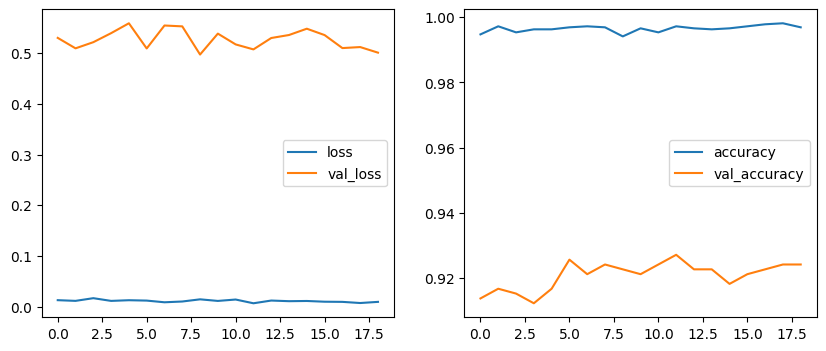

In [18]:
fig, ax = plt.subplots(1, 2, figsize=(10, 4))

history_df = pd.DataFrame(history2.history)
history_df[['loss', 'val_loss']].plot(kind='line', ax=ax[0])
history_df[['accuracy', 'val_accuracy']].plot(kind='line', ax=ax[1]);

In [19]:
y_predict=model.predict(test_generator)

699/699 [==============================] - 6s 7ms/step


In [20]:
import numpy as np
predictions=[]
for y_pred in y_predict:
    predictions.append(np.argmax(y_pred))

predictions = np.array(predictions)
predictions.shape

(699,)

In [21]:
labels = test_generator.labels

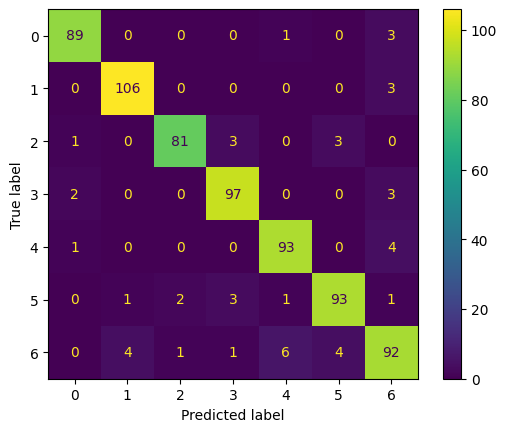

In [22]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(labels, predictions)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.show()

In [23]:
target_names = list(test_generator.class_indices.keys())

In [24]:
target_names

['cardboard', 'compost', 'glass', 'metal', 'paper', 'plastic', 'trash']

In [25]:
from sklearn.metrics import classification_report

print(classification_report(labels, predictions, target_names=target_names))

              precision    recall  f1-score   support

   cardboard       0.96      0.96      0.96        93
     compost       0.95      0.97      0.96       109
       glass       0.96      0.92      0.94        88
       metal       0.93      0.95      0.94       102
       paper       0.92      0.95      0.93        98
     plastic       0.93      0.92      0.93       101
       trash       0.87      0.85      0.86       108

    accuracy                           0.93       699
   macro avg       0.93      0.93      0.93       699
weighted avg       0.93      0.93      0.93       699



## Save model

Sau khi save xong hãy tải xuống và up lên drive

In [26]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [27]:
%cd /content/drive/MyDrive/

/content/drive/MyDrive


In [28]:
!mkdir pretrained_models

In [29]:
%cd pretrained_models

/content/drive/MyDrive/pretrained_models


In [30]:
model.save('MobileNetV2_retrain')

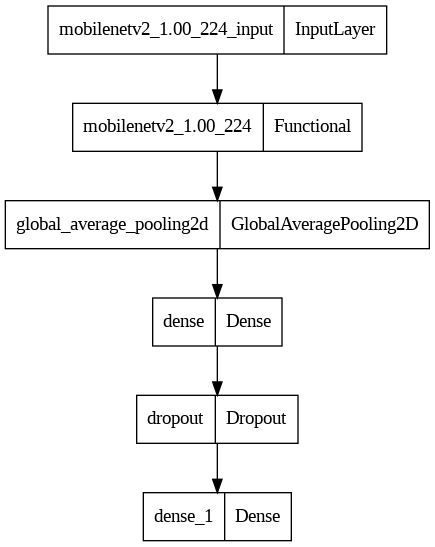

In [31]:
tf.keras.utils.plot_model(
    model,
    to_file="model.png",
    show_shapes=False,
    show_dtype=False,
    show_layer_names=True,
    rankdir="TB",
    expand_nested=False,
    dpi=96,
    layer_range=None,
    show_layer_activations=False,
    show_trainable=False,
)

## Load model

https://drive.google.com/file/d/1N6vUDns4tCbTyFJAfZ5Y2LSCgzPieZl2/view?usp=drive_link

In [38]:
!gdown 1N6vUDns4tCbTyFJAfZ5Y2LSCgzPieZl2

Downloading...
From: https://drive.google.com/uc?id=1N6vUDns4tCbTyFJAfZ5Y2LSCgzPieZl2
To: /content/drive/MyDrive/pretrained_models/MobileNetV2_retrain.zip
100% 32.3M/32.3M [00:00<00:00, 44.3MB/s]


In [39]:
!unzip MobileNetV2_retrain.zip

Archive:  MobileNetV2_retrain.zip
replace MobileNetV2_retrain/variables/variables.data-00000-of-00001? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [ ]:
import tensorflow as tf

# Recreate the exact same model, including its weights and the optimizer
model = tf.keras.models.load_model('MobileNetV2_retrain')

# Show the model architecture
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 8, 8, 2048)        23587712  
                                                                 
 global_average_pooling2d_1   (None, 2048)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dense_2 (Dense)             (None, 512)               1049088   
                                                                 
 dropout_1 (Dropout)         (None, 512)               0         
                                                                 
 dense_3 (Dense)             (None, 7)                 3591      
                                                                 
Total params: 24,640,391
Trainable params: 24,587,271
Non-trainable params: 53,120
_____________________________________

## Error Analysis

In [ ]:
y_predict=model.predict(test_generator)

699/699 [==============================] - 17s 12ms/step


In [32]:
import numpy as np
predictions=[]
for y_pred in y_predict:
    predictions.append(np.argmax(y_pred))

predictions = np.array(predictions)
predictions.shape

(699,)

In [33]:
target_names = list(test_generator.class_indices.keys())

In [34]:
labels = test_generator.labels

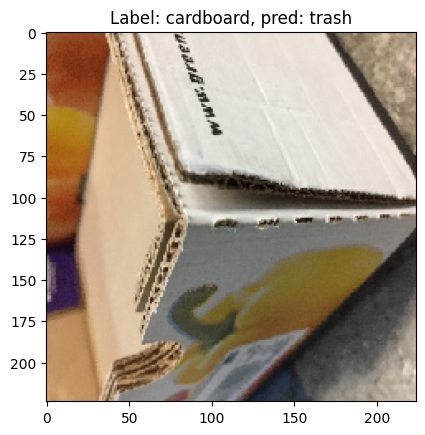

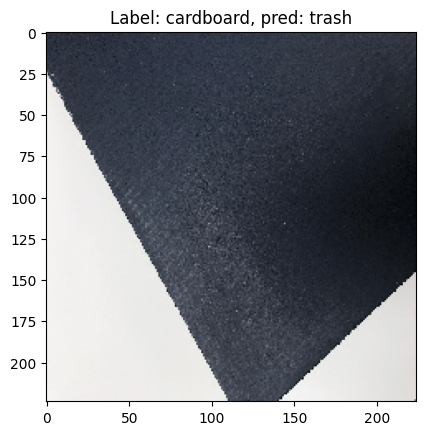

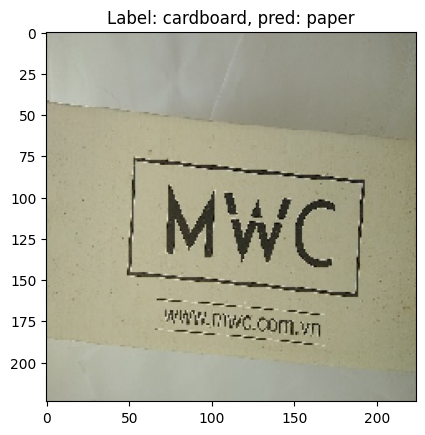

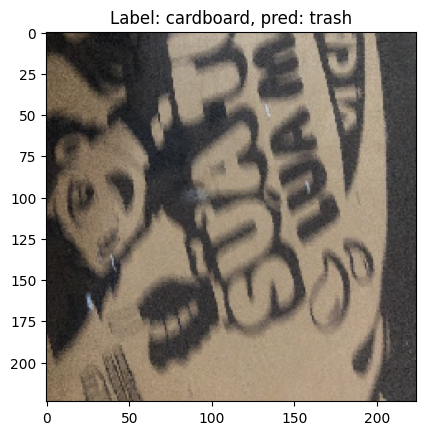

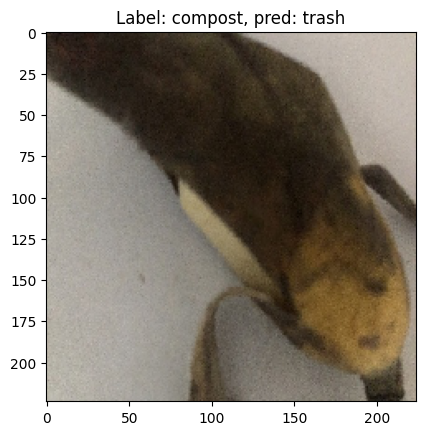

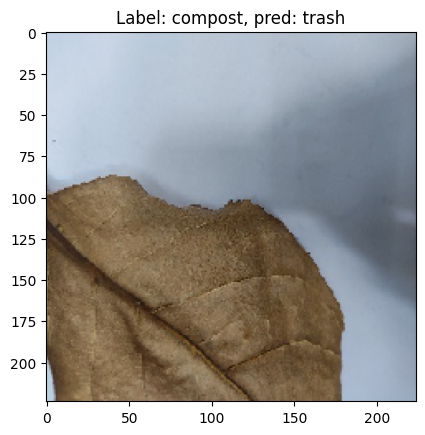

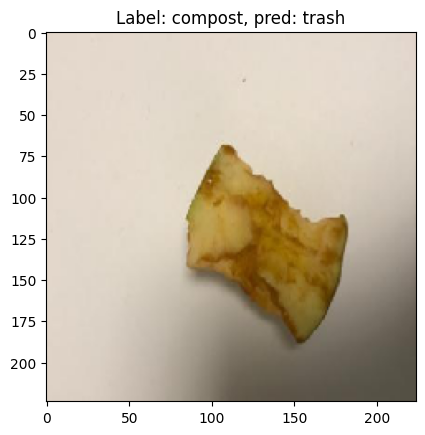

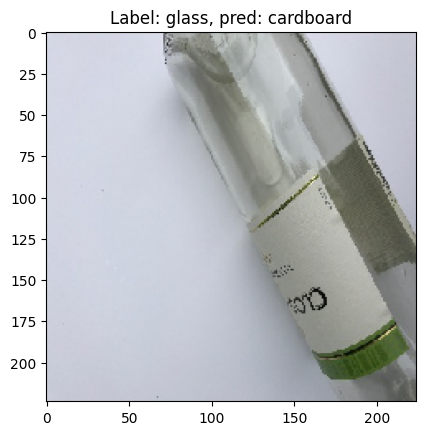

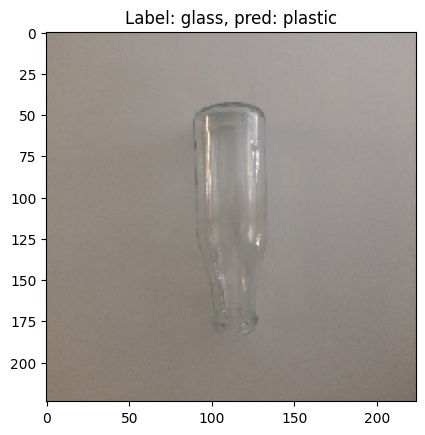

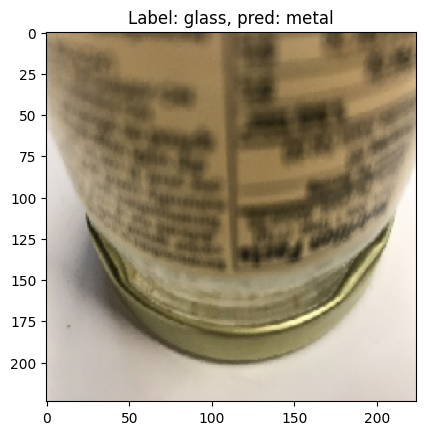

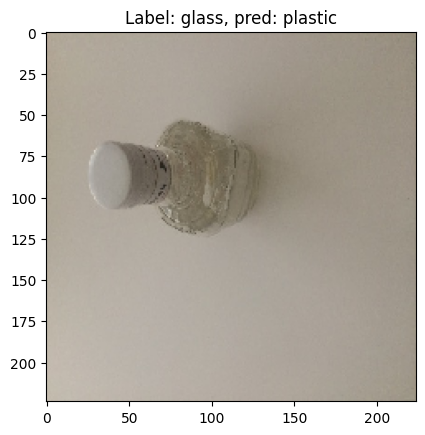

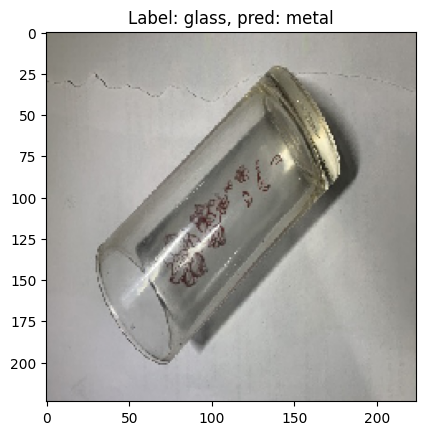

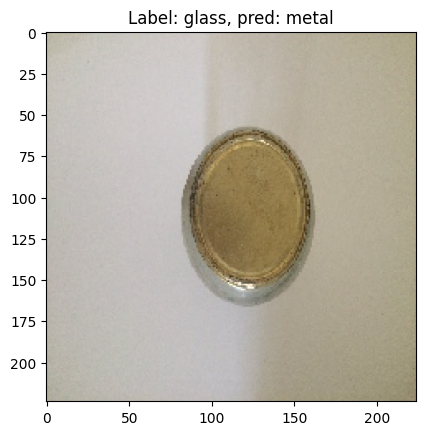

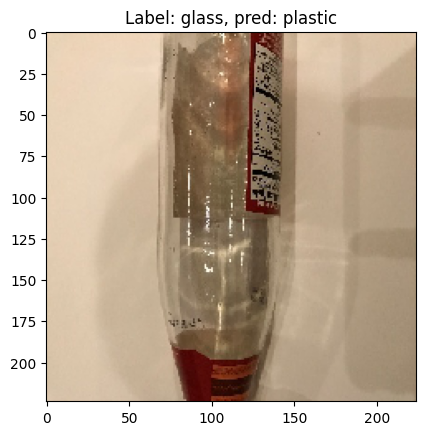

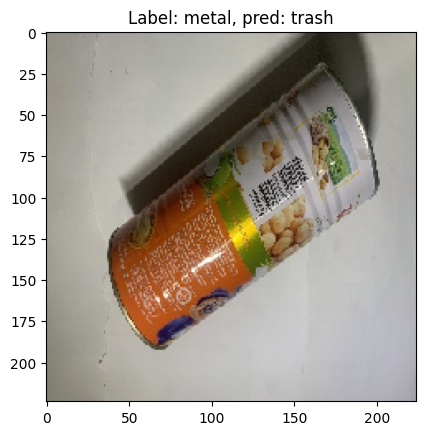

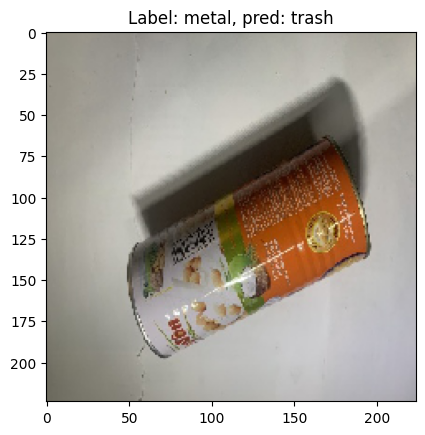

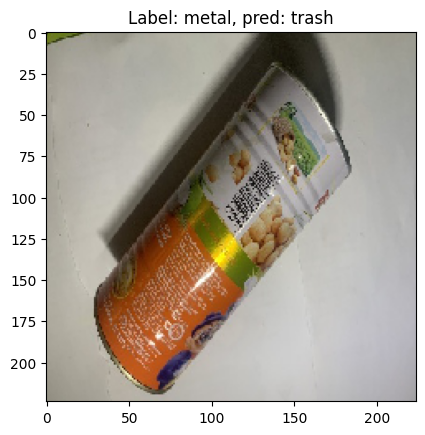

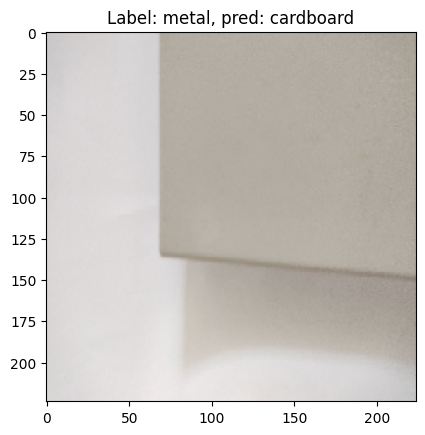

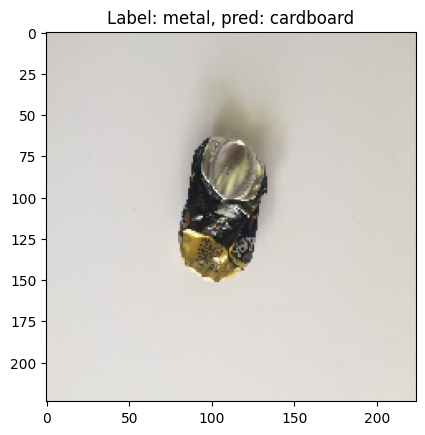

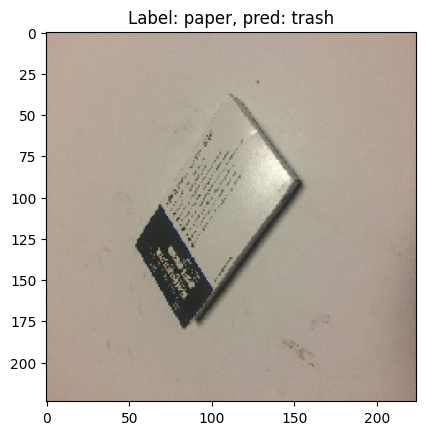

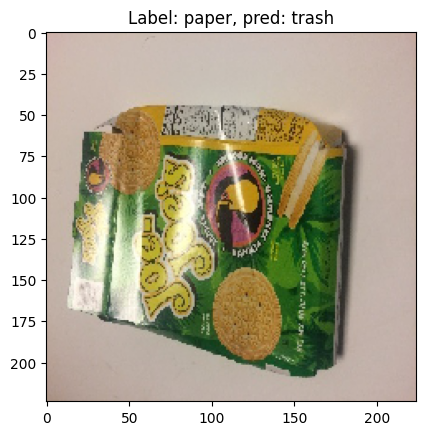

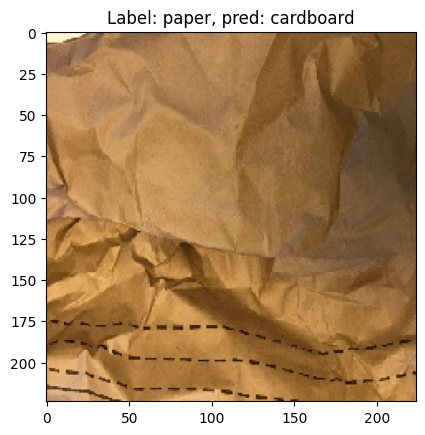

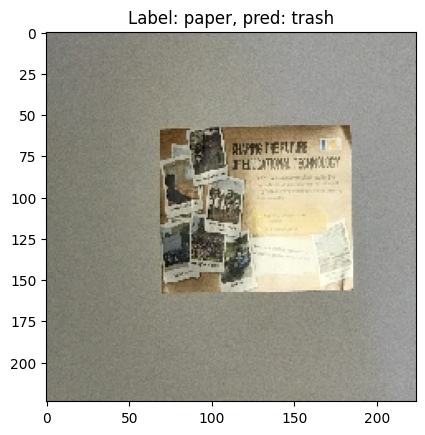

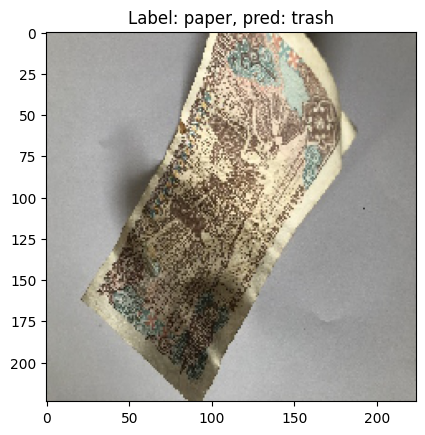

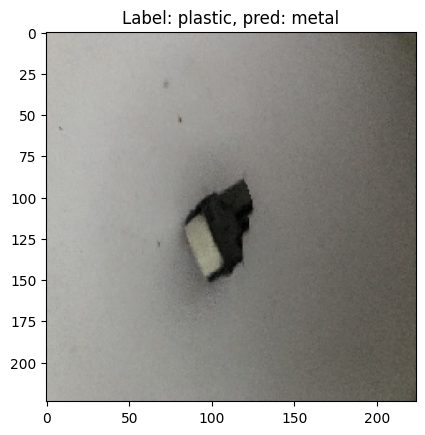

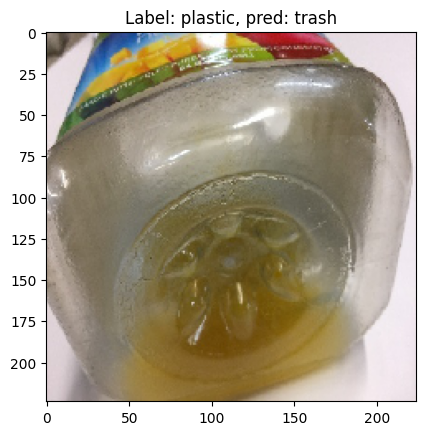

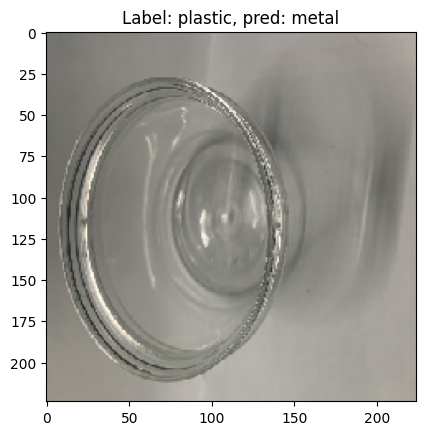

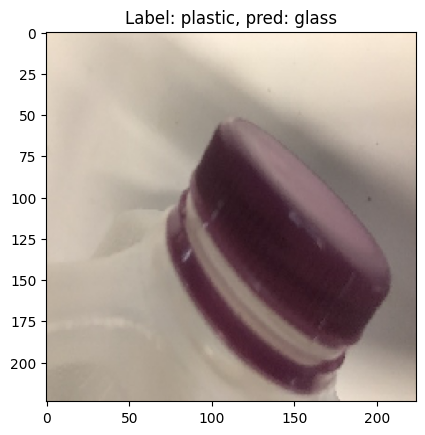

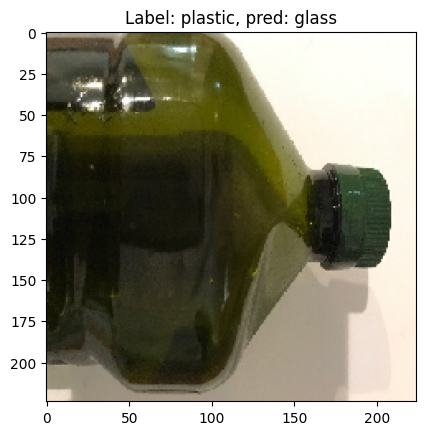

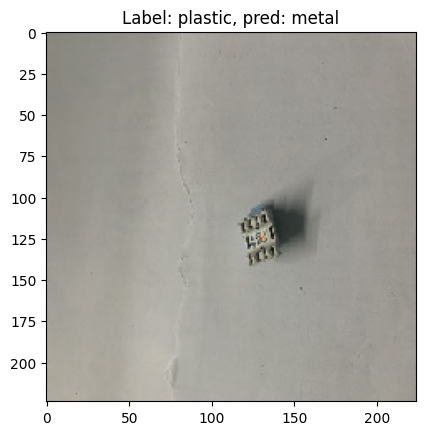

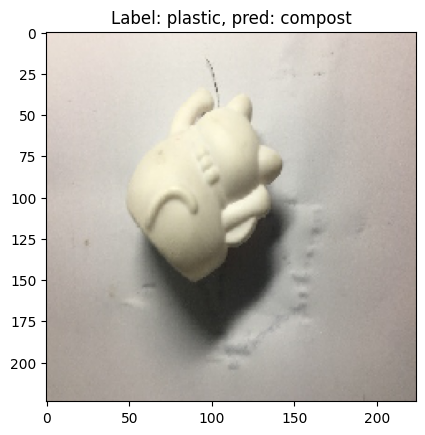

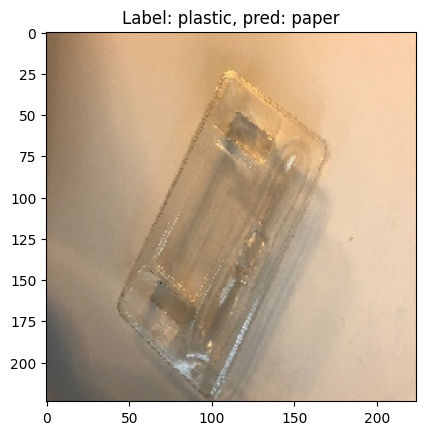

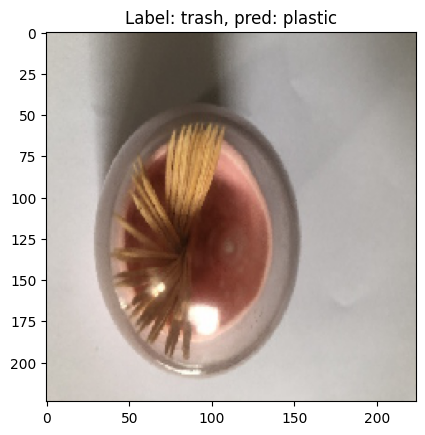

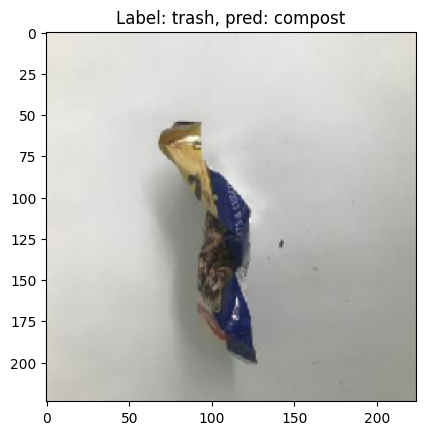

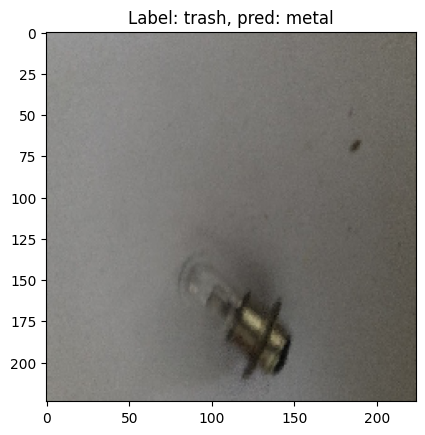

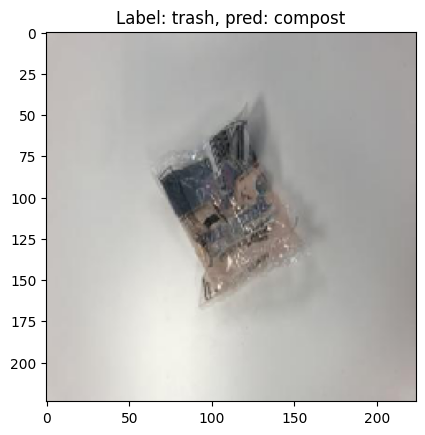

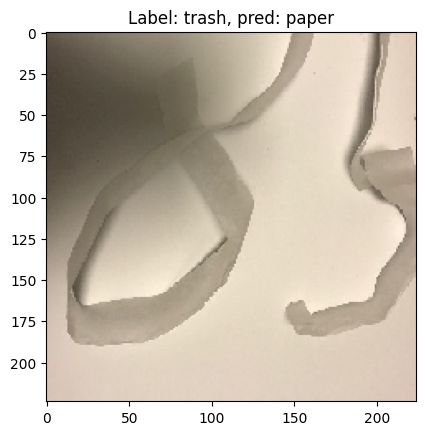

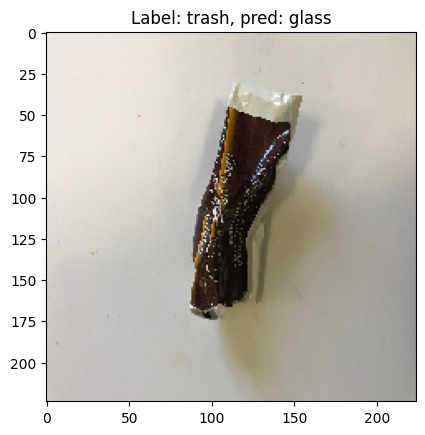

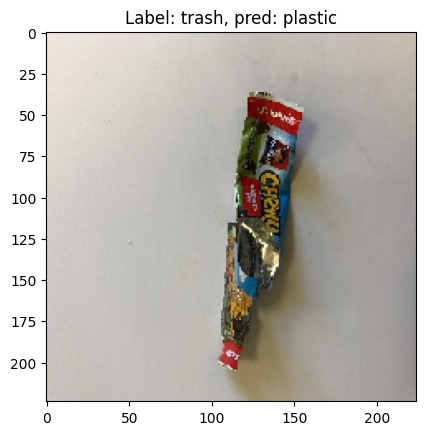

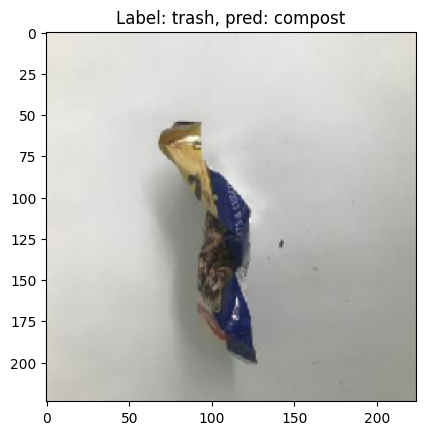

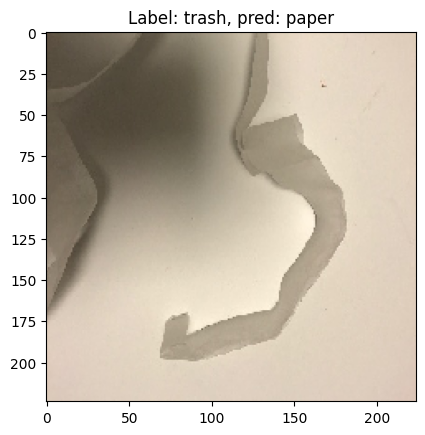

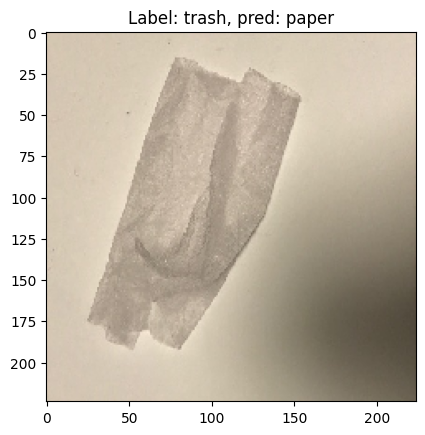

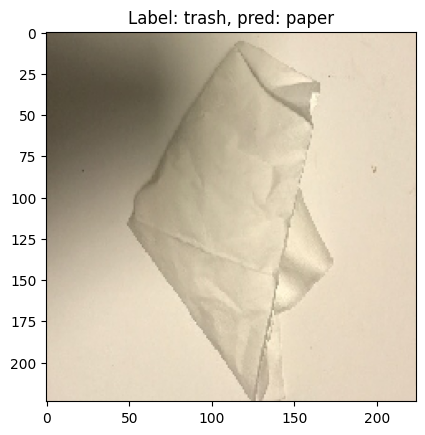

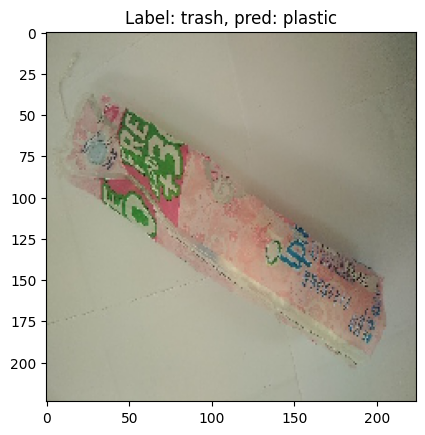

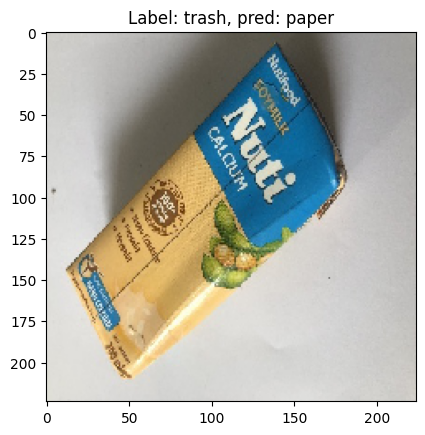

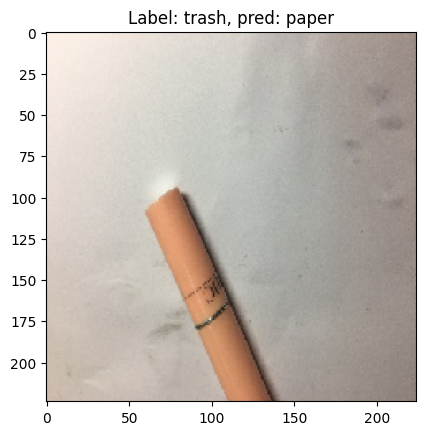

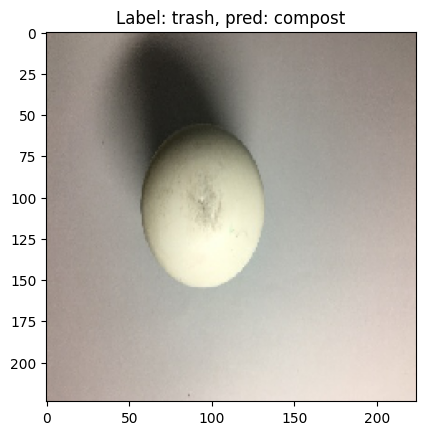

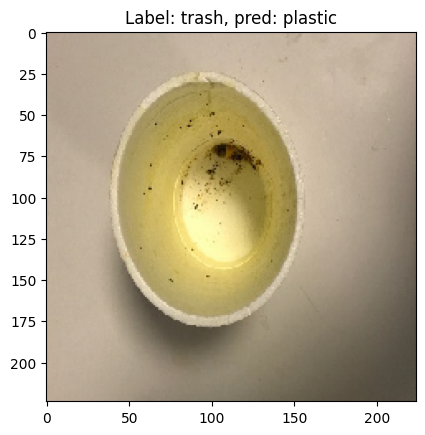

In [35]:
import matplotlib.pyplot as plt


for i in range(0,699):
    x = test_generator.next()
    image = x[0]
    if (labels[i] != predictions[i]):
        plt.imshow(image)
        plt.title(f"Label: {target_names[labels[i]]}, pred: {target_names[predictions[i]]}")
        plt.show()

In [36]:
label_dict = dict(zip(range(7),target_names))
match_label = lambda x: label_dict[x]

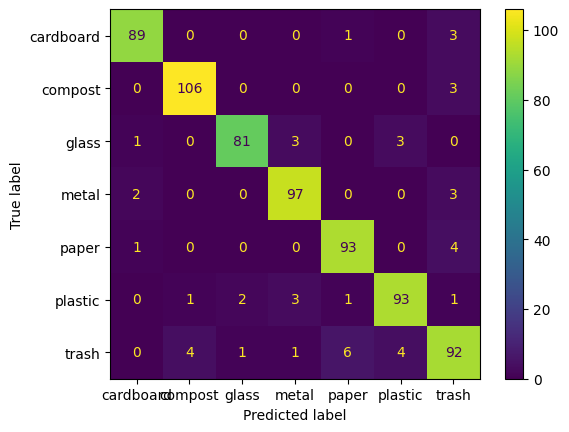

In [37]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(list(map(match_label, labels)), list(map(match_label, predictions)))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=target_names)
disp.plot()
plt.show();